## Euler-Maruyama

In [133]:
%matplotlib inline
import configparser
import matplotlib.pyplot as plt
import numpy as np
import quandl

config = configparser.ConfigParser()
config.read('keys.ini')

['keys.ini']

In [134]:
# start = "2016-01-01"
# end = "2016-12-31"

# quandl.ApiConfig.api_key = config['quandl']['key']
# df = quandl.get("WIKI/AMZN", start_date=start, end_date=end)
# df.head()
# adj_close = df['Adj. Close']
# t_adj_close = np.linspace(1, len(adj_close), len(adj_close))

In [135]:
def compute_drift_and_volatility(adj_close):
    returns = []
    for i in range(len(adj_close) - 1):
        daily_return = (adj_close[i + 1] - adj_close[i]) / adj_close[i]
        returns.append(daily_return)
    
    mu = np.mean(returns)
    sigma = np.std(returns)
    
    return mu, sigma

In [136]:
# Model parameters
mu, sigma = compute_drift_and_volatility(adj_close)

In [137]:
# Simulation parameters
n = 2.**8
T = 252.
dt = T / n
t = np.linspace(0., T, int(n))

In [141]:
def gbm(samp_path, n):
    return np.random.normal(0, 1, (samp_path, int(n)))

In [235]:
def one_coin_noise(samp_path, n):
    return (np.random.binomial(1, 0.5, (samp_path, int(n))) - 0.5) * 2

def two_coin_noise(samp_path, n):
    return (np.random.binomial(2, 0.5, (samp_path, int(n))) - 1) * np.sqrt(2.)

def five_coin_noise(samp_path, n): 
    return (np.random.binomial(5, 0.5, (samp_path, int(n))) - 2.5) * 2. / np.sqrt(5.)

In [236]:
def mean_path(noise_func, s_0, mu, sigma, dt, n, samp_paths=2):
    sqrtdt = np.sqrt(dt)               # Avoiding computing square root at every step

    s = np.zeros((samp_paths, int(n)))      # Initialize matrix for sample paths and time coordinates
    s[:, 0] = s_0                      # Set the intial prices of the paths
    
    noise = noise_func(samp_paths, int(n))  # Generate random noise corresponding to all paths and times
    
    for i in range(int(n) - 1):
        s[:, i + 1] = s[:, i] + mu * dt * s[:, i] + sigma * sqrtdt * s[:, i] * noise[:, i]
    
    mean_path = np.mean(s, axis=0)
    path_dev = np.std(s, axis=0)    
    return mean_path, mean_path - path_dev, mean_path + path_dev

In [237]:
# w, b = gbm(n)

# for i in range(int(n) - 1):
#     drift = (mu - 0.5 * sigma**2) * (i + 1) * dt
#     diffusion = sigma * np.sqrt(dt) * w[i]
#     a[i + 1] = a[0] * np.exp(drift + diffusion)
s, s_l, s_u = mean_path(gbm, adj_close[0], mu, sigma, dt, n, samp_paths=185)
c, c_l, c_u = mean_path(one_coin_noise, adj_close[0], mu, sigma, dt, n, samp_paths=185)
d, d_l, d_u = mean_path(two_coin_noise, adj_close[0], mu, sigma, dt, n, samp_paths=185)
e, e_l, e_u = mean_path(five_coin_noise, adj_close[0], mu, sigma, dt, n, samp_paths=185)

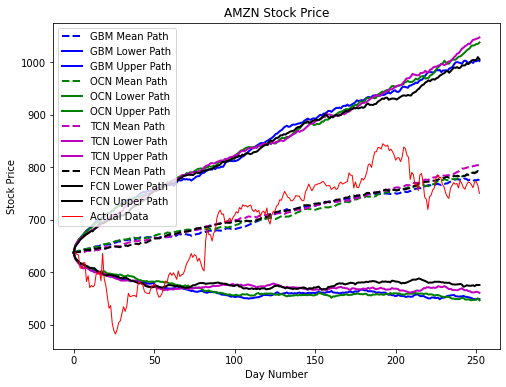

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(t, s, lw=2, color='b', ls='--')
ax.plot(t, s_l, lw=2, color='b')
ax.plot(t, s_u, lw=2, color='b')
ax.plot(t, c, lw=2, color='g', ls='--')
ax.plot(t, c_l, lw=2, color='g')
ax.plot(t, c_u, lw=2, color='g')
ax.plot(t, d, lw=2, color='m', ls='--')
ax.plot(t, d_l, lw=2, color='m')
ax.plot(t, d_u, lw=2, color='m')
ax.plot(t, e, lw=2, color='k', ls='--')
ax.plot(t, e_l, lw=2, color='k')
ax.plot(t, e_u, lw=2, color='k')
ax.plot(t_adj_close, np.ravel(adj_close), lw=1, color='r')
ax.set_title('AMZN Stock Price')
ax.set_xlabel('Day Number')
ax.set_ylabel('Stock Price')
ax.legend(['GBM Mean Path', 'GBM Lower Path', 'GBM Upper Path', 
           'OCN Mean Path', 'OCN Lower Path', 'OCN Upper Path',
           'TCN Mean Path', 'TCN Lower Path', 'TCN Upper Path',
           'FCN Mean Path', 'FCN Lower Path', 'FCN Upper Path',           
           'Actual Data'])